<a href="https://colab.research.google.com/github/Elphin-wq/innovative-intern/blob/main/FORCASTINF_AIR_QUALITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating sample air quality data...
Starting data preprocessing...
Data shape after preprocessing: (8736, 25)

=== Exploratory Data Analysis ===
Dataset Info:
Shape: (8736, 25)
Date range: 2023-01-02 00:00:00 to 2023-12-31 23:00:00


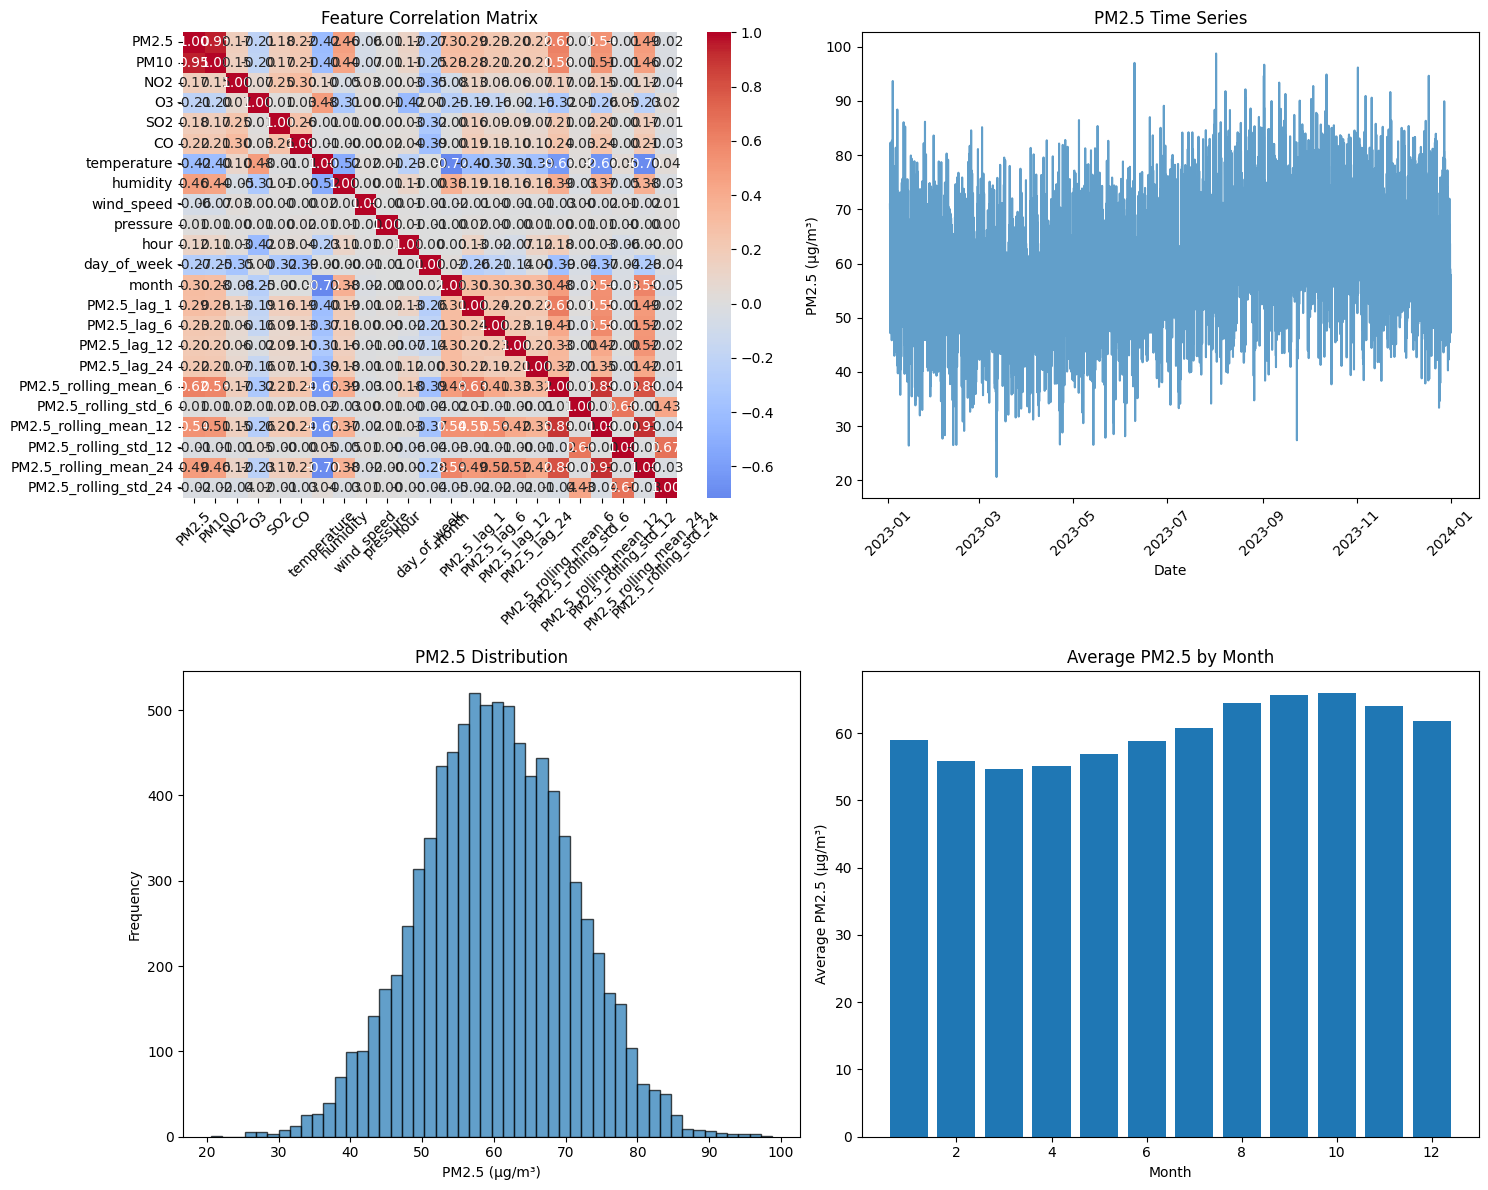

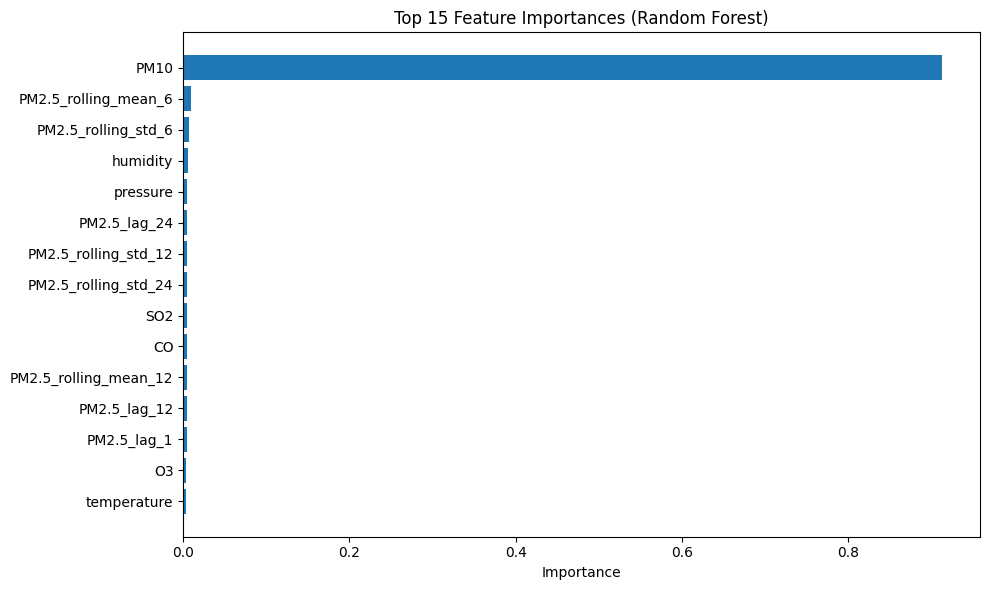

Training set size: 6988
Test set size: 1748

=== Training Traditional ML Models ===
Training Linear Regression...
Linear Regression - Test MAE: 2.364, Test R²: 0.903
Training Random Forest...
Random Forest - Test MAE: 2.405, Test R²: 0.901
Training XGBoost...
XGBoost - Test MAE: 2.546, Test R²: 0.887
Training Gradient Boosting...
Gradient Boosting - Test MAE: 2.376, Test R²: 0.903

=== Training LSTM Model ===
LSTM - Test MAE: 7.397, Test R²: 0.074

=== Model Comparison ===
                   Test MAE   Test R²  Test RMSE
Linear Regression  2.364373  0.903490   2.987667
Gradient Boosting  2.375746  0.902813   2.998125
Random Forest      2.405256  0.901458   3.018945
XGBoost            2.545607  0.887272   3.228941
LSTM               7.397446  0.074022   0.000000

Best Model: Linear Regression (MAE: 2.364)


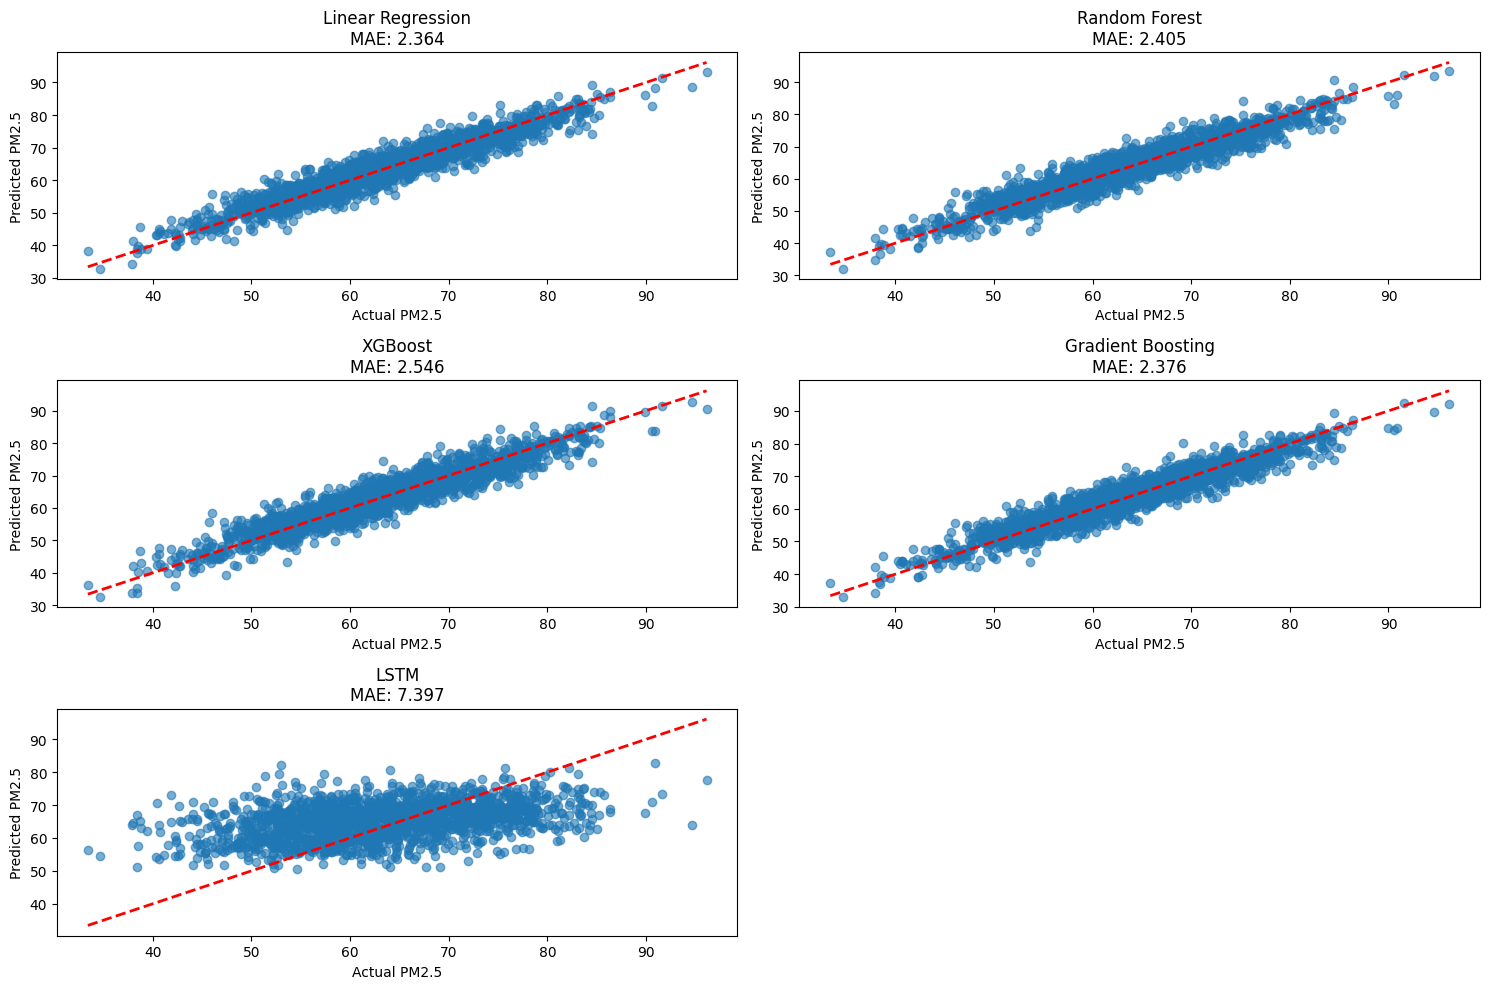


=== Future Predictions (Next 24 hours) ===
             datetime  predicted_PM2.5
0 2024-01-01 00:00:00         57.69055
1 2024-01-01 01:00:00         57.69055
2 2024-01-01 02:00:00         57.69055
3 2024-01-01 03:00:00         57.69055
4 2024-01-01 04:00:00         57.69055
5 2024-01-01 05:00:00         57.69055
6 2024-01-01 06:00:00         57.69055
7 2024-01-01 07:00:00         57.69055
8 2024-01-01 08:00:00         57.69055
9 2024-01-01 09:00:00         57.69055


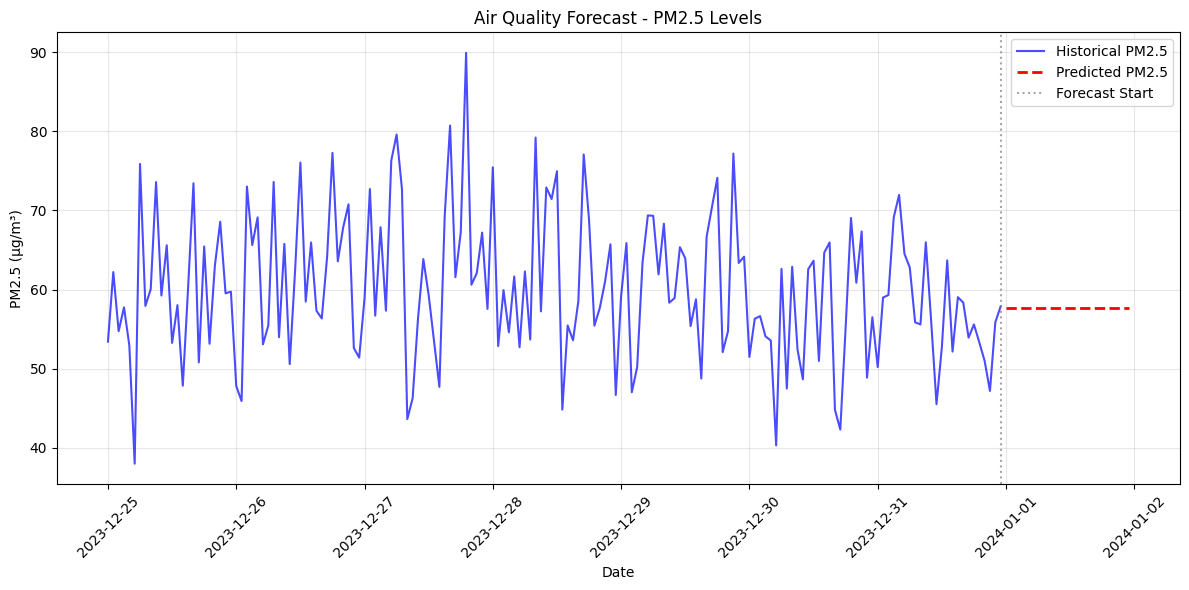


Forecasting complete! Best model: Linear Regression
Average predicted PM2.5 for next 24 hours: 57.69 μg/m³


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For deep learning models
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. LSTM models will be skipped.")

class AirQualityForecaster:
    """
    Comprehensive Air Quality Forecasting System
    Implements multiple ML models for predicting air pollution levels
    """

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_importance = {}
        self.best_model = None
        self.best_score = float('inf')

    def generate_sample_data(self, n_samples=8760):  # 1 year of hourly data
        """
        Generate realistic sample air quality data for demonstration
        """
        np.random.seed(42)

        # Create date range
        dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')

        # Generate weather features with seasonal patterns
        day_of_year = dates.dayofyear
        hour_of_day = dates.hour

        # Temperature with seasonal variation
        temperature = 20 + 15 * np.sin(2 * np.pi * day_of_year / 365) + \
                     5 * np.sin(2 * np.pi * hour_of_day / 24) + \
                     np.random.normal(0, 3, n_samples)

        # Humidity with inverse temperature correlation
        humidity = 60 - 0.5 * temperature + np.random.normal(0, 10, n_samples)
        humidity = np.clip(humidity, 20, 95)

        # Wind speed
        wind_speed = 5 + 3 * np.random.exponential(1, n_samples)
        wind_speed = np.clip(wind_speed, 0, 20)

        # Pressure
        pressure = 1013 + np.random.normal(0, 10, n_samples)

        # Traffic factor (higher during rush hours and weekdays)
        is_weekday = dates.weekday < 5
        rush_hour = ((hour_of_day >= 7) & (hour_of_day <= 9)) | \
                   ((hour_of_day >= 17) & (hour_of_day <= 19))
        traffic_factor = 1 + 0.5 * is_weekday + 0.3 * rush_hour

        # Generate pollutant concentrations with realistic correlations
        # PM2.5 (primary target)
        pm25_base = 25 + 20 * (1 / wind_speed) + 15 * traffic_factor + \
                   0.3 * humidity - 0.2 * temperature
        pm25 = pm25_base + np.random.normal(0, 8, n_samples)
        pm25 = np.clip(pm25, 5, 200)

        # PM10 (correlated with PM2.5)
        pm10 = pm25 * 1.5 + np.random.normal(0, 5, n_samples)
        pm10 = np.clip(pm10, 10, 300)

        # NO2 (traffic-related)
        no2 = 30 + 25 * traffic_factor + 0.1 * temperature + \
              np.random.normal(0, 10, n_samples)
        no2 = np.clip(no2, 5, 100)

        # O3 (temperature and sunlight dependent)
        sunlight_factor = np.maximum(0, np.sin(2 * np.pi * hour_of_day / 24))
        o3 = 40 + 30 * sunlight_factor + 0.5 * temperature - 0.2 * humidity + \
             np.random.normal(0, 15, n_samples)
        o3 = np.clip(o3, 10, 150)

        # SO2 (industrial)
        so2 = 15 + 10 * traffic_factor + np.random.normal(0, 5, n_samples)
        so2 = np.clip(so2, 2, 50)

        # CO (traffic-related)
        co = 1 + 0.8 * traffic_factor + np.random.normal(0, 0.3, n_samples)
        co = np.clip(co, 0.1, 5)

        # Create DataFrame
        data = pd.DataFrame({
            'datetime': dates,
            'PM2.5': pm25,
            'PM10': pm10,
            'NO2': no2,
            'O3': o3,
            'SO2': so2,
            'CO': co,
            'temperature': temperature,
            'humidity': humidity,
            'wind_speed': wind_speed,
            'pressure': pressure,
            'hour': hour_of_day,
            'day_of_week': dates.weekday,
            'month': dates.month,
            'is_weekend': ~is_weekday
        })

        return data

    def preprocess_data(self, data, target_column='PM2.5'):
        """
        Comprehensive data preprocessing pipeline
        """
        print("Starting data preprocessing...")

        # Handle missing values
        imputer = SimpleImputer(strategy='median')
        numeric_columns = data.select_dtypes(include=[np.number]).columns
        data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

        # Feature engineering
        if 'datetime' in data.columns:
            data['datetime'] = pd.to_datetime(data['datetime'])
            data = data.sort_values('datetime')

            # Lag features (previous values)
            for lag in [1, 6, 12, 24]:  # 1hr, 6hr, 12hr, 24hr lags
                data[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)

            # Rolling statistics
            for window in [6, 12, 24]:
                data[f'{target_column}_rolling_mean_{window}'] = \
                    data[target_column].rolling(window=window).mean()
                data[f'{target_column}_rolling_std_{window}'] = \
                    data[target_column].rolling(window=window).std()

        # Drop rows with NaN values created by lag features
        data = data.dropna()

        print(f"Data shape after preprocessing: {data.shape}")
        return data

    def exploratory_data_analysis(self, data):
        """
        Perform comprehensive EDA
        """
        print("\n=== Exploratory Data Analysis ===")

        # Basic statistics
        print("Dataset Info:")
        print(f"Shape: {data.shape}")
        print(f"Date range: {data['datetime'].min()} to {data['datetime'].max()}")

        # Correlation matrix
        plt.figure(figsize=(15, 12))

        # Select numeric columns for correlation
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        correlation_matrix = data[numeric_cols].corr()

        plt.subplot(2, 2, 1)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)

        # Time series plot
        plt.subplot(2, 2, 2)
        plt.plot(data['datetime'], data['PM2.5'], alpha=0.7)
        plt.title('PM2.5 Time Series')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 (μg/m³)')
        plt.xticks(rotation=45)

        # Distribution plot
        plt.subplot(2, 2, 3)
        plt.hist(data['PM2.5'], bins=50, alpha=0.7, edgecolor='black')
        plt.title('PM2.5 Distribution')
        plt.xlabel('PM2.5 (μg/m³)')
        plt.ylabel('Frequency')

        # Seasonal patterns
        plt.subplot(2, 2, 4)
        monthly_avg = data.groupby('month')['PM2.5'].mean()
        plt.bar(monthly_avg.index, monthly_avg.values)
        plt.title('Average PM2.5 by Month')
        plt.xlabel('Month')
        plt.ylabel('Average PM2.5 (μg/m³)')

        plt.tight_layout()
        plt.show()

        # Feature importance using Random Forest
        feature_cols = [col for col in numeric_cols if col not in ['PM2.5'] and 'datetime' not in col]
        if feature_cols:
            rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_temp.fit(data[feature_cols], data['PM2.5'])

            importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': rf_temp.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 6))
            plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
            plt.title('Top 15 Feature Importances (Random Forest)')
            plt.xlabel('Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

    def prepare_features(self, data, target_column='PM2.5'):
        """
        Prepare features and target for modeling
        """
        # Exclude non-predictive columns
        exclude_cols = ['datetime', target_column]
        feature_cols = [col for col in data.columns if col not in exclude_cols]

        X = data[feature_cols]
        y = data[target_column]

        return X, y, feature_cols

    def train_traditional_models(self, X_train, X_test, y_train, y_test):
        """
        Train traditional ML models
        """
        print("\n=== Training Traditional ML Models ===")

        models_config = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }

        results = {}

        for name, model in models_config.items():
            print(f"Training {name}...")

            # Scale features for models that benefit from it
            if name in ['Linear Regression']:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                self.scalers[name] = scaler
            else:
                X_train_scaled = X_train
                X_test_scaled = X_test
                self.scalers[name] = None

            # Train model
            model.fit(X_train_scaled, y_train)

            # Predictions
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)

            # Evaluate
            train_mae = mean_absolute_error(y_train, y_pred_train)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)

            results[name] = {
                'model': model,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'predictions': y_pred_test
            }

            # Store model
            self.models[name] = model

            # Update best model
            if test_mae < self.best_score:
                self.best_score = test_mae
                self.best_model = name

            print(f"{name} - Test MAE: {test_mae:.3f}, Test R²: {test_r2:.3f}")

        return results

    def create_lstm_model(self, input_shape):
        """
        Create LSTM model for time series forecasting
        """
        model = Sequential([
            Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape),
            Dropout(0.2),
            Bidirectional(LSTM(50, return_sequences=False)),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'])

        return model

    def prepare_lstm_data(self, data, target_column='PM2.5', sequence_length=24):
        """
        Prepare data for LSTM model
        """
        # Scale the data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data.select_dtypes(include=[np.number]))

        # Create sequences
        X, y = [], []
        target_idx = data.select_dtypes(include=[np.number]).columns.get_loc(target_column)

        for i in range(sequence_length, len(scaled_data)):
            X.append(scaled_data[i-sequence_length:i])
            y.append(scaled_data[i, target_idx])

        return np.array(X), np.array(y), scaler

    def train_lstm_model(self, data, target_column='PM2.5'):
        """
        Train LSTM model if TensorFlow is available
        """
        if not TENSORFLOW_AVAILABLE:
            print("Skipping LSTM model - TensorFlow not available")
            return None

        print("\n=== Training LSTM Model ===")

        # Prepare LSTM data
        X_lstm, y_lstm, lstm_scaler = self.prepare_lstm_data(data, target_column)

        # Split data
        split_idx = int(0.8 * len(X_lstm))
        X_train_lstm = X_lstm[:split_idx]
        X_test_lstm = X_lstm[split_idx:]
        y_train_lstm = y_lstm[:split_idx]
        y_test_lstm = y_lstm[split_idx:]

        # Create and train model
        lstm_model = self.create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))

        history = lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )

        # Predictions
        y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0)

        # Inverse transform predictions
        dummy_array = np.zeros((len(y_pred_lstm), X_lstm.shape[2]))
        target_idx = data.select_dtypes(include=[np.number]).columns.get_loc(target_column)
        dummy_array[:, target_idx] = y_pred_lstm.flatten()
        y_pred_lstm_original = lstm_scaler.inverse_transform(dummy_array)[:, target_idx]

        dummy_array_test = np.zeros((len(y_test_lstm), X_lstm.shape[2]))
        dummy_array_test[:, target_idx] = y_test_lstm
        y_test_lstm_original = lstm_scaler.inverse_transform(dummy_array_test)[:, target_idx]

        # Evaluate
        lstm_mae = mean_absolute_error(y_test_lstm_original, y_pred_lstm_original)
        lstm_r2 = r2_score(y_test_lstm_original, y_pred_lstm_original)

        self.models['LSTM'] = lstm_model
        self.scalers['LSTM'] = lstm_scaler

        if lstm_mae < self.best_score:
            self.best_score = lstm_mae
            self.best_model = 'LSTM'

        print(f"LSTM - Test MAE: {lstm_mae:.3f}, Test R²: {lstm_r2:.3f}")

        return {
            'model': lstm_model,
            'test_mae': lstm_mae,
            'test_r2': lstm_r2,
            'predictions': y_pred_lstm_original,
            'actual': y_test_lstm_original,
            'history': history
        }

    def evaluate_models(self, results):
        """
        Compare model performance
        """
        print("\n=== Model Comparison ===")

        comparison_df = pd.DataFrame({
            model_name: {
                'Test MAE': results[model_name]['test_mae'],
                'Test R²': results[model_name].get('test_r2', 0),
                'Test RMSE': results[model_name].get('test_rmse', 0)
            }
            for model_name in results.keys()
        }).T

        comparison_df = comparison_df.sort_values('Test MAE')
        print(comparison_df)

        print(f"\nBest Model: {self.best_model} (MAE: {self.best_score:.3f})")

        return comparison_df

    def visualize_predictions(self, results, actual_values):
        """
        Visualize model predictions
        """
        plt.figure(figsize=(15, 10))

        n_models = len(results)
        n_cols = 2
        n_rows = (n_models + 1) // n_cols

        for i, (model_name, result) in enumerate(results.items()):
            plt.subplot(n_rows, n_cols, i + 1)

            if model_name == 'LSTM' and 'actual' in result:
                actual = result['actual']
                predictions = result['predictions']
            else:
                actual = actual_values
                predictions = result['predictions']

            # Plot scatter plot
            plt.scatter(actual, predictions, alpha=0.6)
            plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
            plt.xlabel('Actual PM2.5')
            plt.ylabel('Predicted PM2.5')
            plt.title(f'{model_name}\nMAE: {result.get("test_mae", result.get("mae", 0)):.3f}')

        plt.tight_layout()
        plt.show()

    def predict_future(self, model_name, data, periods=24):
        """
        Make future predictions
        """
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found")

        model = self.models[model_name]
        scaler = self.scalers.get(model_name)

        # Get the last row of features
        exclude_cols = ['datetime', 'PM2.5']
        feature_cols = [col for col in data.columns if col not in exclude_cols]
        last_features = data[feature_cols].iloc[-1:].values

        predictions = []

        for _ in range(periods):
            if scaler:
                scaled_features = scaler.transform(last_features)
                pred = model.predict(scaled_features)[0]
            else:
                pred = model.predict(last_features)[0]

            predictions.append(pred)

            # Update lag features for next prediction (simplified)
            # In practice, you'd want more sophisticated feature updating

        return predictions

def main():
    # Initialize forecaster
    forecaster = AirQualityForecaster()

    # Generate sample data
    print("Generating sample air quality data...")
    data = forecaster.generate_sample_data(n_samples=8760)  # 1 year

    # Preprocess data
    data = forecaster.preprocess_data(data)

    # Exploratory Data Analysis
    forecaster.exploratory_data_analysis(data)

    # Prepare features
    X, y, feature_cols = forecaster.prepare_features(data)

    # Split data (time series split)
    split_idx = int(0.8 * len(X))
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Train traditional models
    traditional_results = forecaster.train_traditional_models(X_train, X_test, y_train, y_test)

    # Train LSTM model
    lstm_results = forecaster.train_lstm_model(data)

    # Combine results
    all_results = traditional_results.copy()
    if lstm_results:
        all_results['LSTM'] = lstm_results

    # Evaluate and compare models
    comparison = forecaster.evaluate_models(all_results)

    # Visualize predictions
    forecaster.visualize_predictions(all_results, y_test)

    # Make future predictions
    print(f"\n=== Future Predictions (Next 24 hours) ===")
    future_predictions = forecaster.predict_future(forecaster.best_model, data, periods=24)

    # Create future timeline
    last_datetime = data['datetime'].iloc[-1]
    future_dates = [last_datetime + timedelta(hours=i+1) for i in range(24)]

    future_df = pd.DataFrame({
        'datetime': future_dates,
        'predicted_PM2.5': future_predictions
    })

    print(future_df.head(10))

    # Plot future predictions
    plt.figure(figsize=(12, 6))

    # Plot last 7 days of actual data
    recent_data = data.tail(168)  # Last 7 days
    plt.plot(recent_data['datetime'], recent_data['PM2.5'],
             label='Historical PM2.5', color='blue', alpha=0.7)

    # Plot future predictions
    plt.plot(future_dates, future_predictions,
             label='Predicted PM2.5', color='red', linestyle='--', linewidth=2)

    plt.axvline(x=last_datetime, color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.title('Air Quality Forecast - PM2.5 Levels')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nForecasting complete! Best model: {forecaster.best_model}")
    print(f"Average predicted PM2.5 for next 24 hours: {np.mean(future_predictions):.2f} μg/m³")

    return forecaster, data, all_results

if __name__ == "__main__":
    forecaster, data, results = main()